In [34]:
import os
import gc
import time
import math
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

from PIL import Image
from tqdm import tqdm
from torchvision import models
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms import v2 as transforms
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
# Define seed for random
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Read Datasets

In [5]:
# Set directories and file paths
DATASET_DIR = "/media/luchocode/Extra Vol/ExoNet_Images/ExoNet_Images"
LABELS_FILE = "/home/luchocode/Downloads/Labels.csv"
DATAFRAMES_DIR = "/media/luchocode/Extra Vol/Datasets/Tesis/"

In [6]:
seq_train_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "seq_train_df.pkl"))
seq_val_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "seq_val_df.pkl"))
test_df = pd.read_pickle(os.path.join(DATAFRAMES_DIR, "test_df.pkl"))

In [7]:
seq_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641800 entries, 0 to 641799
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video        641800 non-null  object
 1   frame        641800 non-null  int64 
 2   class        641800 non-null  object
 3   video_chunk  641800 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.6+ MB


# Generate Dataloaders

In [8]:
class ExoNetDataset(Dataset):
    def __init__(
        self,
        df_labels: pd.DataFrame,
        seq_len: int,
        img_dir: str,
        transform=None,
        target_transform=None
    ):
        self.img_labels = df_labels
        self.seq_len = seq_len
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)//self.seq_len

    def __getitem__(self, idx):
        """
        Return an image and its label
        """
        start_seq_idx = idx * self.seq_len
        end_seq_idx = (idx+1) * self.seq_len
        file_name_format = "['{}'] frame {}.jpg"
        frames = [
            Image.open(
                os.path.join(
                    self.img_dir,
                    self.img_labels.iloc[i, 2],
                    file_name_format.format(
                        self.img_labels.iloc[i, 0],
                        self.img_labels.iloc[i, 1]
                    )
                )
            ).convert("RGB") for i in range(start_seq_idx, end_seq_idx)
        ]
        labels = [self.img_labels.iloc[i, 2] for i in range(start_seq_idx, end_seq_idx)]        
        
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
        if self.target_transform:
            labels = self.target_transform(labels)

        frames_tensor = torch.stack(frames)
        labels_tensor = torch.from_numpy(labels)

        return frames_tensor, labels_tensor


In [9]:
# Transforms
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
MEAN_DATASET = [0.485, 0.456, 0.406]
STD_DATASET = [0.229, 0.224, 0.225]

unique_labels = seq_train_df['class'].unique()
encoder = LabelBinarizer()
encoder.fit(unique_labels)

train_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    ),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
])

val_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    )
])

test_image_transform = transforms.Compose([
    transforms.Resize((IMAGE_WIDTH, IMAGE_HEIGHT)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(
        mean=MEAN_DATASET,
        std=STD_DATASET
    )
])

In [10]:
# Datasets objects
SEQUENCE_LENGTH = 100
training_dataset = ExoNetDataset(
    df_labels=seq_train_df,
    img_dir=DATASET_DIR,
    seq_len=SEQUENCE_LENGTH,
    target_transform=encoder.transform,
    transform=train_image_transform
)
validation_dataset = ExoNetDataset(
    df_labels=seq_val_df,
    img_dir=DATASET_DIR,
    seq_len=SEQUENCE_LENGTH,
    target_transform=encoder.transform,
    transform=val_image_transform
)
print(f"[Training] Total video chunks of {SEQUENCE_LENGTH} frames: {len(training_dataset)}")
print(f"[Validation] Total video chunks of {SEQUENCE_LENGTH} frames: {len(validation_dataset)}")

frames_tensor, labels_tensor = training_dataset[0]
print(f"Frames shape: {frames_tensor.shape}. Labels shape: {labels_tensor.shape}")


[Training] Total video chunks of 100 frames: 6418
[Validation] Total video chunks of 100 frames: 1754
Frames shape: torch.Size([100, 3, 224, 224]). Labels shape: torch.Size([100, 12])


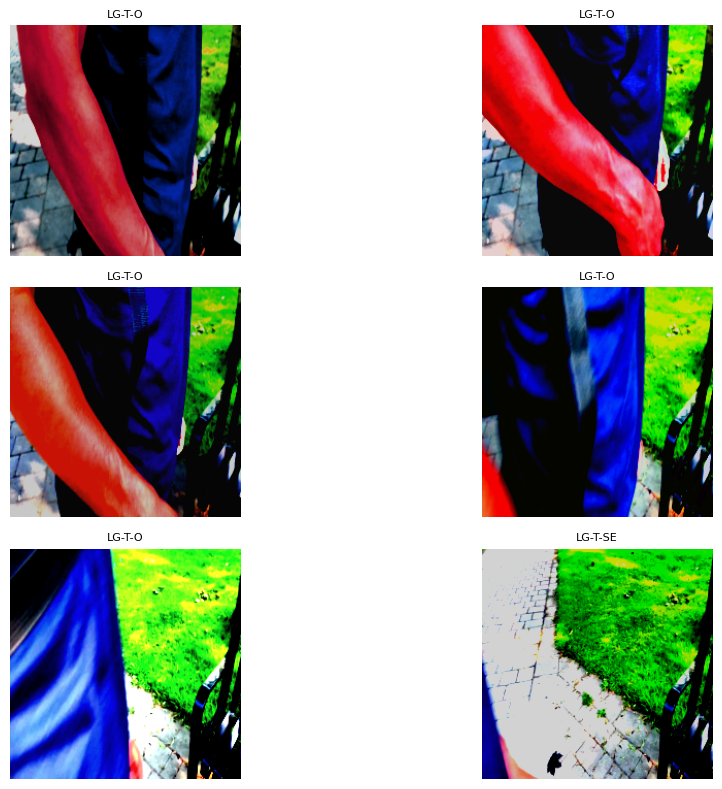

In [11]:
# Visualize images using the training dataset created above
def show_images_in_grid(
    tensor_images,
    labels_images,
    cols=3,
    figsize=(12, 8)
):
    """
    Display images in a grid layout.

    Args:
        tensor_images (tensor): A tensor object.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    n_images = len(tensor_images)
    rows = math.ceil(n_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for ax, img_tensor, label in zip(axes, tensor_images, labels_images):
        try:
            img = img_tensor.clone()
            img = img.permute(1,2,0)
            img = img.numpy()
            ax.imshow(img)
            ax.set_title(label, fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center")
            ax.axis("off")

    # Hide empty subplots if any
    for ax in axes[n_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_images_in_grid(
    tensor_images=frames_tensor[10:16,],
    labels_images=encoder.inverse_transform(labels_tensor[10:16,]),
    cols=2
)

In [12]:
# Create the dataloaders
BATCH_SIZE = 64

train_dataloader = torch.utils.data.DataLoader(
    training_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=6,
    pin_memory=True
)

val_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=6,
    pin_memory=True
)

# Create Neural Networks

## ConvLSTM n channels

In [16]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, bias=True):
        super().__init__()
        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.hidden_channels = hidden_channels

        self.conv = nn.Conv2d(
            input_channels + hidden_channels,
            4 * hidden_channels,
            kernel_size,
            padding=padding,
            bias=bias,
        )

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_out, 4, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [19]:
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels_list, kernel_size, num_classes):
        super().__init__()
        self.num_layers = len(hidden_channels_list)

        layers = []
        for i in range(self.num_layers):
            in_channels = input_channels if i == 0 else hidden_channels_list[i - 1]
            layers.append(ConvLSTMCell(in_channels, hidden_channels_list[i], kernel_size[i]))
        self.layers = nn.ModuleList(layers)
        self.avg_pool_2d = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.classifier = nn.Linear(hidden_channels_list[-1], num_classes)

    def forward(self, x, h=None, c=None):
        # x: (B, T, C, H, W) -> feature maps from EfficientNet
        B, T, _, H, W = x.size()

        if h is None:
            h = [torch.zeros(B, ch, H, W, device=x.device) for ch in self._hidden_channels]
            c = [torch.zeros(B, ch, H, W, device=x.device) for ch in self._hidden_channels]

        outputs = []
        for t in range(T): # For each timestep in the sequence
            input_t = x[:, t]

            for layer_idx, cell in enumerate(self.layers):
                h[layer_idx], c[layer_idx] = cell(input_t, h[layer_idx], c[layer_idx])
                input_t = h[layer_idx]

            pooled = self.avg_pool_2d(h[-1])  # (B, C_hidden, 1, 1)
            pooled = pooled.view(B, -1)  # (B, C_hidden)

            frame_output = self.classifier(pooled)  # (B, num_classes)
            outputs.append(frame_output)

        outputs = torch.stack(outputs, dim=1)  # (B, T, num_classes)
        return outputs, h, c

    @property
    def _hidden_channels(self):
        return [cell.hidden_channels for cell in self.layers]


In [56]:
class CnnExtractorConvLSTM(nn.Module):
    def __init__(self, hidden_channels_list, kernel_size, num_classes, device, feature_extractor, feature_dim, name):
        super().__init__()
        self.name = name
        self.feature_extractor = feature_extractor
        self.feature_extractor = self.feature_extractor.to(device=device)

        # ConvLSTM on top of feature maps
        self.convlstm = ConvLSTM(
            input_channels=feature_dim,
            hidden_channels_list=hidden_channels_list,
            kernel_size=kernel_size,
            num_classes=num_classes,
        )

    def forward(self, x, h=None, c=None):
        # x: (B, T, 3, H, W) raw RGB frames
        B, T, C, H, W = x.size()

        features = []
        for t in range(T):
            with torch.no_grad():
                f_t = self.feature_extractor(x[:, t])  # (B, 1280, H', W')
                features.append(f_t)

        features = torch.stack(features, dim=1)  # (B, T, C_feat, H', W')

        out, h_prev, c_prev = self.convlstm(features, h, c)  # (B, T, num_classes)
        return out, h_prev, c_prev


In [58]:
def test(m_test, batch_size, seq_length, channels=3, heigth=224, weigth=224):
    m_test.eval()
    x = torch.randn(BATCH_SIZE, SEQUENCE_LENGTH, 3, IMAGE_HEIGHT, IMAGE_WIDTH).to("cuda")
    out, h, c = m_test(x)
    out, h, c = m_test(x, h, c)
    print(out.shape, len(h), len(c))

## EfficientNetB0 with convLSTM

In [46]:
efficientnet_convLSTM = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_convLSTM_dim = 1280
efficientnet_name = "EfficientNetB0_convLSTM"

In [60]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=efficientnet_convLSTM.features,
    feature_dim=efficientnet_convLSTM_dim,
    name=efficientnet_name
).to(device="cuda")
test(m_test, BATCH_SIZE, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 100, 12]) 2 2
torch.Size([64, 100, 12]) 2 2


## MobileNetV2 with convLSTM

In [50]:
mobnet_convLSTM = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
mobnet_convLSTM_dim = 1280
mobnet_name = "MobileNetV2_convLSTM"

In [61]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=mobnet_convLSTM.features,
    feature_dim=mobnet_convLSTM_dim,
    name=mobnet_name
).to(device="cuda")
test(m_test, BATCH_SIZE, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 100, 12]) 2 2
torch.Size([64, 100, 12]) 2 2


## VGG16 with convLSTM

In [55]:
vgg16_convLSTM = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
vgg16_convLSTM_dim = 512
vgg16_name = "VGG16_convLSTM"

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/luchocode/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|████████████████████████████████████████| 528M/528M [03:25<00:00, 2.69MB/s]


In [62]:
# test
m_test = CnnExtractorConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device="cuda",
    feature_extractor=vgg16_convLSTM.features,
    feature_dim=vgg16_convLSTM_dim,
    name=vgg16_name
).to(device="cuda")
test(m_test, BATCH_SIZE, SEQUENCE_LENGTH)
test(m_test, 1, 1)

torch.Size([64, 100, 12]) 2 2
torch.Size([64, 100, 12]) 2 2


# Training

In [63]:
# load previous state
def load_state(PATH, device):
    try:
        checkpoint = torch.load(PATH, map_location=device)
        return checkpoint
    except Exception as e:
        print(f"The state couldn't be loaded. Exception: {e}")
        return None

# save current state
def save_state(PATH, model, optimizer, epoch, loss):
    try:
        torch.save({
            'current_epoch': epoch,
            'loss': loss,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, PATH)
    except Exception as e:
        print(f"State couldn't be saved. Exception: {e}")

In [23]:
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.BCEWithLogitsLoss()
model = EfficientNetConvLSTM(
    num_classes=len(unique_labels),
    hidden_channels_list=[128, 64],
    kernel_size=[(3,3),(3,3)],
    device=device
).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

CHECKPOINT_PATH = "./checkpoints/convlstm.pth"
checkpoint = load_state(CHECKPOINT_PATH, device=device)

if checkpoint:
    current_epoch = checkpoint['current_epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    current_epoch = 1


The state couldn't be loaded. Exception: [Errno 2] No such file or directory: './checkpoints/convlstm.pth'


In [24]:
# Training loop
for epoch in range(current_epoch, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_dataloader, total=len(train_dataloader), leave=True)
    loop.set_description(f"Epoch [{epoch}/{epochs}]")
    
    for i, (xb, yb) in enumerate(loop, start=1):
        xb = xb.to(device)
        yb = yb.to(device).float()

        optimizer.zero_grad() # zero the parameter gradients
        logits = model(xb).float() # forward pass
        loss = criterion(logits, yb)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # gradient clipping
        optimizer.step() # update weights

        running_loss += loss.item() * xb.size(0)

        preds = (torch.sigmoid(logits) > 0.5).float()
        correct += (preds == yb).float().sum()
        total += torch.numel(yb)
        
        loop.set_postfix(loss=(running_loss/len(loop)), acc=f"{(correct/total):.4f}")
        
        del xb, yb, logits, loss, preds

    epoch_loss = running_loss / len(train_dataloader)
    epoch_acc = correct / total
    save_state(CHECKPOINT_PATH, model, optimizer, epoch)

    # validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    val_len = len(val_dataloader)
    with torch.no_grad():
        val_loop = tqdm(val_dataloader, total=len(val_dataloader), leave=False)
        val_loop.set_description("Validation")
        
        for j, (xb, yb) in enumerate(val_dataloader, start=1):
            xb = xb.to(device)
            yb = yb.to(device).float()

            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item() * xb.size(0)

            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == yb).sum().item()
            val_total += torch.numel(yb)

            val_loop.set_postfix(loss=val_loss/len(val_loop), acc=f"{(val_correct/val_total):.4f}")
    
    val_loss = val_loss / val_len
    val_acc = val_correct / val_total

Epoch [1/10]: 100%|█████████████████████████████████████| 201/201 [13:44<00:00,  4.10s/it, acc=0.9148, loss=7.9]


State saved successfully!


Epoch [2/10]: 100%|█████████████████████████████████████| 201/201 [13:57<00:00,  4.17s/it, acc=0.9167, loss=7.3]


State saved successfully!



                                                                                                                
Epoch [3/10]: 100%|███████████████████████████████████████| 201/201 [13:16<00:00,  3.96s/it, acc=0.9198, loss=7]


State saved successfully!


Epoch [4/10]: 100%|█████████████████████████████████████| 201/201 [14:01<00:00,  4.19s/it, acc=0.9261, loss=6.5]


State saved successfully!



                                                                                                                
Epoch [5/10]: 100%|████████████████████████████████████| 201/201 [13:51<00:00,  4.13s/it, acc=0.9310, loss=5.89]


State saved successfully!


Epoch [6/10]: 100%|████████████████████████████████████| 201/201 [13:15<00:00,  3.96s/it, acc=0.9356, loss=5.53]


State saved successfully!



                                                                                                                
Epoch [7/10]: 100%|████████████████████████████████████| 201/201 [14:03<00:00,  4.20s/it, acc=0.9381, loss=5.29]


State saved successfully!


Epoch [8/10]: 100%|████████████████████████████████████| 201/201 [13:53<00:00,  4.15s/it, acc=0.9403, loss=5.07]


State saved successfully!



                                                                                                                
Epoch [9/10]: 100%|████████████████████████████████████| 201/201 [13:55<00:00,  4.16s/it, acc=0.9419, loss=4.91]


State saved successfully!


Epoch [10/10]: 100%|███████████████████████████████████| 201/201 [13:46<00:00,  4.11s/it, acc=0.9439, loss=4.75]


State saved successfully!



                                                                                                                
Validation:   0%|                                                   | 0/55 [02:41<?, ?it/s, acc=0.8680, loss=11]